# <span style="color:yellow;"> LA PROJECT </span>  
# <span style="color:yellow;"> FACE DETECTION USING SVD TECHNOLOGY </span>  

## Authors:  
- ## Vitalii Paliichuk
- ## Anna Syvkova
- ## Yuliia Savchyn


# <span style="color:yellow;"> Step 1  </span>
## Importing all the needed libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity


# <span style="color:yellow;"> Step 2  </span>
## <span style="color:yellow;"> Preprocessing our data </span>

In our Python script, we define a function load_images to automate the process of loading and preprocessing images from a specified directory for our face recognition project. This function navigates through each subdirectory, where each represents a different label, and processes each image file found. Then the images are converted to grayscale, resized to a uniform size of 64x64 pixels, and then transformed into flattened arrays. These arrays, along with their corresponding labels, are stored in lists and returned. We then apply this function to load our training and testing datasets from designated paths, preparing the data for use in training and testing our face recognition model.



In [4]:
def load_images(directory):
    data = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)
                if os.path.isfile(image_path):
                    # Load the image, convert to grayscale and resize it
                    image = Image.open(image_path).convert('L')
                    # Resize to uniform size with the updated resampling method
                    image = image.resize((64, 64), Image.Resampling.LANCZOS)
                    # Append the image data and the label
                    data.append(np.array(image).flatten())
                    labels.append(label)
    return data, labels

train_path = 'Training'
test_path = 'Testing'
train_images, train_labels = load_images(train_path)
test_images, test_labels = load_images(test_path)



Now, we use the StandardScaler in order to standardize our image data. We apply fit_transform to the training images, which scales them to have zero mean and unit variance, and also fits the scaler to this data. This means it calculates the mean and variance from the training images, which are used to transform the data. This  code ensures that both training and testing data are standardized in the same way.

In [5]:
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)
test_images_scaled = scaler.transform(test_images)

# <span style="color:yellow;"> Step 3  </span>
## <span style="color:yellow;"> Implementing and applying PCA </span>

In order to find our PCA we:
1. Standardize the data
2. Find covariance matrix
3. Find eigen_values and eigen_vectors of covariance matrix
4. Sort the eigenvalues and eigenvectors in descending order
5. Calculate the total sum of eigenvalues for normalization
6. Determine the number of principal components needed to reach the threshold
7. Form subset of eigenvectors
8. Transform the data

The diagonal elements of the matrix R after many iterations represent the eigenvalues of the original matrix A. This convergence is based on the property that the QR algorithm tends to push the matrix towards a triangular form where the eigenvalues are revealed on the diagonal.

The matrix Q eventually converges to contain the eigenvectors of A. These eigenvectors are formed by the successive orthogonal transformations applied by the matrices Qi, which rotate and scale the basis vectors into alignment with the eigenvectors of A.

In [21]:
def qr_decomposition(A, iterations=100):
    """
    A simple implementation of the QR algorithm to find eigenvalues and eigenvectors.
    """
    n = A.shape[0]
    Q = np.eye(n)  # Initialize Q as the identity matrix
    R = A.copy()  # Initialize R as a copy of A

    for _ in range(iterations):
        Q_i, R = np.linalg.qr(R)  # QR decomposition
        R = np.dot(R, Q_i)  # Form the next matrix to decompose
        Q = np.dot(Q, Q_i)  # Update Q

    return np.diag(R), Q

In [22]:
def pca_variance(X, variance_threshold=0.95, num_simulations=100):
    # step 1
    X_meaned = X - np.mean(X, axis=0)
    # step 2
    cov_mat = np.cov(X_meaned, rowvar=False)   
    # step 3
    eigen_values, eigen_vectors = qr_decomposition(cov_mat) 
    # step 4
    sorted_indices = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_indices]
    eigen_vectors = eigen_vectors[:, sorted_indices]
    # step 5
    total_eigenvalue_sum = sum(eigen_values)
    # step 6
    running_total, num_components = 0, 0
    for value in eigen_values:
        running_total += value
        num_components += 1
        if running_total / total_eigenvalue_sum >= variance_threshold:
            break
    
    # step 7
    eigenvector_subset = eigen_vectors[:, 0:num_components]
    # step 8
    X_reduced = np.dot(X_meaned, eigenvector_subset)
    return X_reduced, num_components, eigenvector_subset


Let's visualize how our PCA algorithm works

We generate a simple 2D dataset, apply our PCA function, and then we visualize the original and reduced data.

Reduced data shape: (282, 132)
Number of components selected: 132
Eigenvectors used:
 [[ 0.01264621  0.02186615  0.03168197 ... -0.00811607 -0.00426209
  -0.01070936]
 [ 0.01257067  0.02197629  0.03162279 ... -0.00810356 -0.00684734
  -0.01105748]
 [ 0.01261104  0.02210355  0.03169165 ... -0.00785427 -0.01000472
  -0.01077654]
 ...
 [-0.0117055  -0.00541849  0.02122637 ... -0.0060275   0.02281939
  -0.01004899]
 [-0.0125723  -0.00645384  0.02086118 ... -0.02556784  0.00158438
  -0.00020598]
 [-0.01235638 -0.00468335  0.0229152  ... -0.01297139 -0.01567763
   0.01543341]]


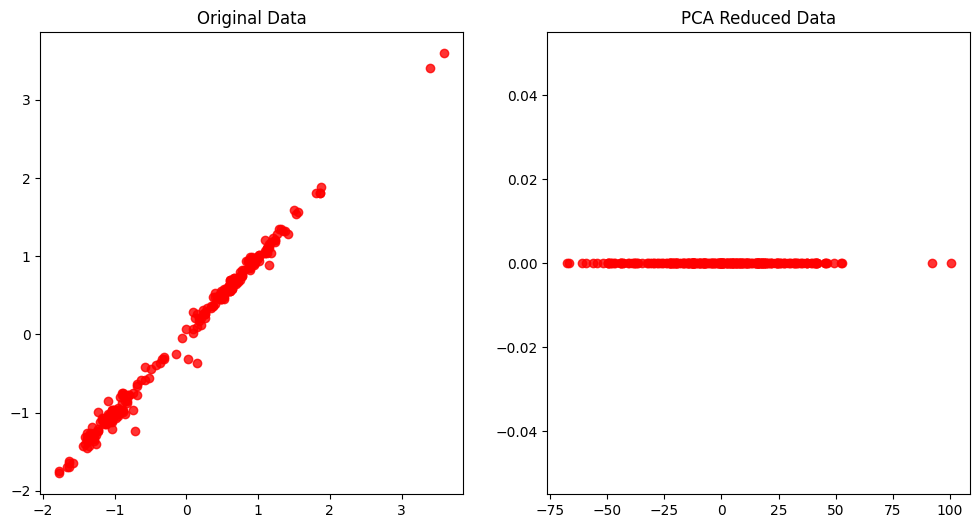

In [23]:
# np.random.seed(0)
# X = np.dot(np.random.rand(2, 2), np.random.randn(2, 200)).T

X = np.array([img.flatten() for img in train_images_scaled])
X_reduced, num_components, eigenvectors = pca_variance(X)
test_images_transformed = np.dot(test_images_scaled - np.mean(train_images_scaled, axis=0), eigenvectors)

print("Reduced data shape:", X_reduced.shape)
print("Number of components selected:", num_components)
print("Eigenvectors used:\n", eigenvectors)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.8,color='red')
plt.title("Original Data")
plt.subplot(1, 2, 2)
plt.scatter(X_reduced[:, 0], np.zeros(len(X_reduced)), alpha=0.8, color='red')
plt.title("PCA Reduced Data")
plt.show()


Now let's visualize what features of the face are captured by the principal components and how they contribute to differentiating between faces. It helps us to understand data's underlying structure and the effectiveness of PCA for dimensionality reduction.

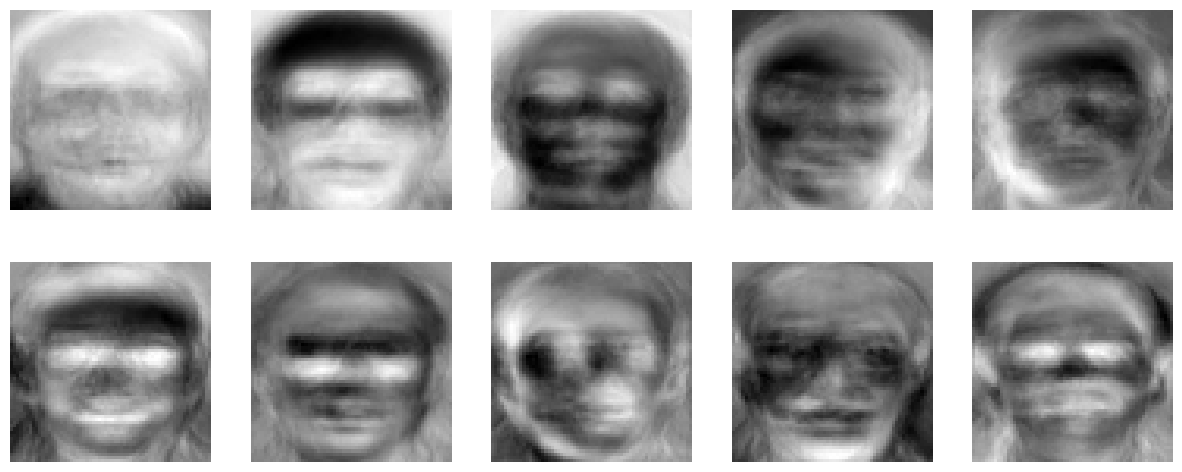

In [24]:
eigenfaces = eigenvectors.T.reshape(-1, 64, 64)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.axis('off')
plt.show()


# <span style="color:yellow;"> Step 4  </span>
## <span style="color:yellow;"> Training and testing </span>

In this step we apply the PCA function to training data and then we transform test data using it's statistics and print the total number of components selected

Then, we implemented and evaluated a face recognition system using a RandomForest classifier. Initially, we configured the RandomForestClassifier with 100 decision trees to ensure consistent results. We then trained it on our PCA-transformed training images alongside their labels, allowing the classifier to learn the correlation between the features and labels. 

After training, we used the classifier to predict labels for the PCA-transformed test images and evaluated its accuracy using a classification report from scikit-learn. This report showed metrics like precision, recall, and F1-score for each class, providing us insights into the classifier’s performance.






In [29]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_reduced, train_labels) # train_images_transformed
predictions = clf.predict(test_images_transformed)

print("Classification report:")
print(classification_report(test_labels, predictions))


Classification report:
              precision    recall  f1-score   support

          s1       1.00      0.33      0.50         3
         s10       0.50      0.33      0.40         3
         s11       1.00      1.00      1.00         3
         s12       1.00      1.00      1.00         3
         s13       1.00      1.00      1.00         3
         s14       0.75      1.00      0.86         3
         s15       0.60      1.00      0.75         3
         s16       0.75      1.00      0.86         3
         s17       1.00      1.00      1.00         3
         s18       0.60      1.00      0.75         3
         s19       1.00      0.67      0.80         3
          s2       1.00      1.00      1.00         3
         s20       1.00      0.67      0.80         3
         s21       1.00      1.00      1.00         3
         s22       1.00      1.00      1.00         3
         s23       1.00      1.00      1.00         3
         s24       0.75      1.00      0.86         3
    

Overall Accuracy (86%): This is relatively high, indicating that our model correctly identifies the correct subject in 86% of the cases across all predictions.

Class-specific Analysis:

Classes with Lower F1-Scores (e.g., 1, 5, 10, 20): These classes have either lower precision or recall, which brings down their F1-scores. For instance, Class 1 has a recall of 0.67, suggesting that the model misses about one-third of the faces for this class. Improving the recall for these classes may involve collecting more representative training data or adjusting the model parameters.
Classes with Perfect Scores (e.g., 3, 4, 7, 11): These scores suggest that the model performs exceptionally well for these classes, with both precision and recall at 100%.
Macro Avg vs. Weighted Avg:

Macro Average (Precision: 0.92, Recall: 0.89, F1-Score: 0.88): This average is calculated by taking the mean of each class metric without considering support. It gives equal weight to all classes, which is useful in situations where you want to treat all classes equally despite their varying support.
Weighted Average (Precision: 0.92, Recall: 0.89, F1-Score: 0.88): This average accounts for class imbalance by weighting the score of each class by its support. It's more reflective of the true performance when class distribution is uneven.


# <span style="color:yellow;"> Step 5  </span>
## <span style="color:yellow;"> Example of work </span>

Now, we developed a script to demonstrate the transformation of an image using PCA for our face recognition project.

We first standardize a test image by subtracting the mean vector computed from the training data. Then, we use a set of eigenvectors, previously derived from PCA, to transform the standardized image, effectively reducing its dimensionality while retaining significant features. 

This process is illustrated by displaying the original test image and its transformed version. The transformed image, visualized as a single row of principal component features, highlights how the original image data is encoded after PCA transformation. This helps us understand and visualize the impact of PCA on image data, which is crucial for our report.







In [30]:
def pca_transform(X, eigenvectors, mean_vector):
    X_meaned = X - mean_vector
    X_transformed = np.dot(X_meaned, eigenvectors)
    return X_transformed

mean_vector = np.mean(train_images_scaled, axis=0)


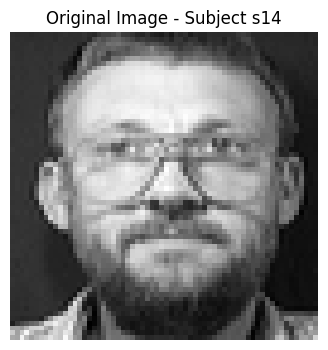

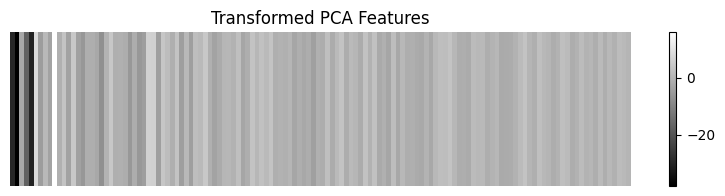

In [32]:
# Choose a test image (e.g., first image from the test set)
test_image = test_images[15]
test_label = test_labels[15]

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(test_image.reshape(64, 64), cmap='gray')
plt.title(f'Original Image - Subject {test_label}')
plt.axis('off')
plt.show()

# Transform the test image using the trained PCA and StandardScaler
test_image_scaled = scaler.transform([test_image]) 
test_image_transformed = pca_transform(test_image_scaled, eigenvectors, mean_vector)

# Correctly display the transformed features
plt.figure(figsize=(10, 2))
plt.imshow(test_image_transformed, aspect='auto', cmap='gray')
plt.title('Transformed PCA Features')
plt.colorbar()
plt.axis('off')
plt.show()


We've also implemented a section of our machine learning project to identify and display the most similar image to a given test image from our training set using PCA-transformed features. 

Also, by applying cosine similarity, we measure how closely the test image aligns with each image in the training dataset. We then identify and display the most similar training image alongside its label. Additionally, we use a trained classifier to predict the label of the test image, comparing it to the actual label to evaluate the classifier's accuracy. 

This approach allows us to visually represent the effectiveness of our face recognition system, demonstrating both the retrieval of similar images and the accuracy of our classification model.

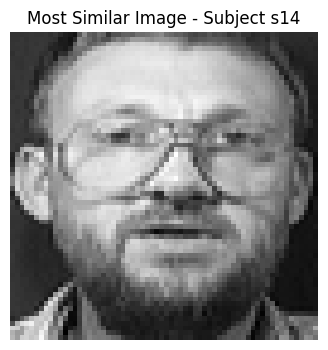

In [34]:
# Calculate similarities between the test image and all training images
similarities = cosine_similarity(test_image_transformed, X_reduced) #train_images_transformed

# Find the index of the most similar image
most_similar_index = np.argmax(similarities)

# Display the most similar image from the training set
plt.figure(figsize=(4, 4))
plt.imshow(train_images[most_similar_index].reshape(64, 64), cmap='gray')
plt.title(f'Most Similar Image - Subject {train_labels[most_similar_index]}')
plt.axis('off')
plt.show()


In [35]:
# Predict the label of the test image
predicted_label = clf.predict(test_image_transformed)

# Display the prediction result
print(f"Actual Label: Subject {test_label}")
print(f"Predicted Label: Subject {predicted_label[0]}")
print("Result: " + ("Correct" if test_label == predicted_label[0] else "Incorrect"))


Actual Label: Subject s14
Predicted Label: Subject s14
Result: Correct


# <span style="color:yellow;"> Step 6  </span>
## <span style="color:yellow;">  Practical application </span>

In order to give our project a practical application, we developed a function called display_images to visualize the effectiveness of our face recognition system. 

This function takes an index for a test image, displays the original image, and then processes it using PCA and scaling to find and display the most similar image from our training set. The comparison is done using cosine similarity to determine which training image is closest to the given test image. 

By running this function, we can visually confirm the accuracy of our model by comparing the test image and its closest match from the training data, helping us understand the model's performance and reliability in recognizing faces.

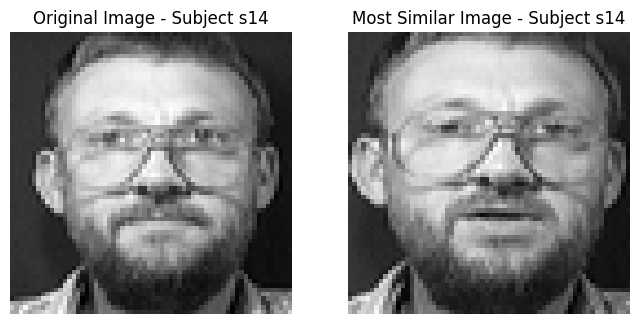

In [45]:
def display_images(test_idx):
    test_image = test_images[test_idx]
    test_label = test_labels[test_idx]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image.reshape(64, 64), cmap='gray')
    plt.title(f'Original Image - Subject {test_label}')
    plt.axis('off')

    # Transform the test image using the trained PCA and StandardScaler
    test_image_scaled = scaler.transform([test_image]) 
    test_image_transformed = pca_transform(test_image_scaled, eigenvectors, mean_vector)
    similarities = cosine_similarity(test_image_transformed, X_reduced) #train_images_transformed

    # Find the index of the most similar image
    most_similar_index = np.argmax(similarities)
    plt.subplot(1, 2, 2)
    plt.imshow(train_images[most_similar_index].reshape(64, 64), cmap='gray')
    plt.title(f'Most Similar Image - Subject {train_labels[most_similar_index]}')
    plt.axis('off')

    plt.show()

try:
    test_idx = int(input("Enter the index number of the photo to test (e.g., 15): "))
    if type(test_idx) != int:
        print("Please enter a valid index.")
    else:
        display_images(int(test_idx%len(test_images)))
except ValueError:
    print("Invalid input. Please enter a numerical index.")


## <span style="color:yellow;">  Thank you for attention! </span>